# FGS Commissioning Tool Tutorial

This tutorial will walk you through how to use the various tools within the FGS Commissioning Tools package. These tools comprise of four main components:

> ### 1. NIRCam to FGS Image Conversion (``nircam_to_fgs``)
This tool can take in a simulated (or real) NIRCam image and will convert it to an FGS (guider 1 or guider 2) image. In addition to rotating the image, adjusting the pixel scale and image size, this tool corrects bad pixels and normalizes the image to a specific magnitude of star.

> ### 2. Star Selection Tool (``star_selector``)
This tool will take the FGS image either created with the first tool, or an FGS image that it is passed by the user, and allow the user to choose the guide star and reference stars using a GUI.

> ### 3. Flight Software File Creation (``fsw_file_writer``)
This module requires an FGS image and a file that includes a list of the coordinates of the guide star and reference stars, along with their count rates. This tool will create all files necessary to test this image different flight software simulators (FGS DHAS, FGSES, etc.) These include all the files necessary to run the ID, ACQ1, ACQ2, and TRK steps in these simulators.

> ### 4. Segment Guiding Tool (``segment_guiding``)
Used to faciliate guiding on unstacked segment arrays during commissioning. When provided 1) the commanded RA and Dec of a guide star and 2) the V2/V3 (or x/y) positions of all segments in an array, the segment guiding tool calculates the effective RA and Dec of all segments on the sky. Let's begin!

These components can be run together (e.g. input a NIRCam image, output flight software and segment guiding files for user-selected guide and reference stars) or individually (e.g. convert a number of NIRCam image to FGS images; generate a segment guiding file from a list of segment coordinates, etc...).

### Tutorial Table of Contents:
* End-to-End tutorial
     * [Example: CMIMF + FGS](#CMIMFFGS)
     * [Example: GA + NIRCam](#GANIRCam)
* Individual module tutorials:
    * [Image Conversion to FGS](#nircamtofgs)
    * [Selecting Stars](#starselector)
    * [Writing files for flight software](#fswfilewriter)
    * [Using the segment guiding tool](#segmentguiding)
* How to use the tools in IPython
    
***

# Getting Started

Before we begin, be sure to check that:
* You have installed the **`jwst_fgs_commissioning_tools`** package (as instructed in the readme)
* You are operating in a **Python 3** environment
* You have [**`pysiaf`**](https://grit.stsci.edu/ins-tel/jwst_siaf_prototype) installed
* You have **photutils** installed

In [3]:
from jwst_fgs_commissioning_tools import run_fgs_commissioning_tool

In [4]:
import os
from glob import glob
from astropy.io import fits
from astropy.io import ascii as asc
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
% matplotlib inline

<a id='CommTool'></a>
## End-to-end Tutorial: Using `run_fgs_commissioning_tool`

The function that is used to run the tool end-to-end is `run_fgs_commissioning_tool.run_all()`. It will automatically call, in the appropriate succession, `nircam_to_fgs`, `star_selector`, and `fsw_file_writer`. This function takes a number of arguments:

>Required:
* **`input_image`** - filepath for the input (NIRCam or FGS) image 
* **`guider`** - number for guider 1 or guider 2

>Optional:
* **`root`** - if defined, will be used to create the output directory, `./out/{root}`. If not provided, the root name will be derived from the `input_image` filename.
* **`nircam`** - denotes if the `input_image` is an FGS or NIRCam image. If `True`, the image will be converted to FGS format using the `nircam_to_fgs.convert_im` function. The FGS-formatted image will be saved to `./out/{input_image}/FGS_imgs/{input_image}_binned_pad_norm.fits`
* **`global_alignment`** - set to `True` if the provided image is from global alignment, or the PSF-finding algorithm will go haywire.
* **`nircam_det`** - is used to specify the detector of a provided NIRCam image. If left blank, the detector will be extracted from the header of the NIRCam FITS file.
* **`fgs_counts`** and **`jmag`** - used to normalize the input NIRCam image, either to a desired J magnitude or to a desired number of FGS counts. The `jmag` parameter can also be used to normalize an FGS image.
* **`in_file`** - a table of X/Y pixel coordinates and count rates that lists the desired guide star and reference stars; provided in the form of a filepath to a `regfile.txt` or `.incat` file
* **`bkgd_stars`** - a developing feature that includes a number of background stars in the final image

Unless otherwise specified, the tool will prompt the user to select guide and reference stars interactively with a GUI. (If you want to bypass the GUI and provide the (x, y) locations and countrates of the guide star and reference star with an incat file or a regfile, provide the appropriate filepath to the `in_file` argument.)
<img src="FGSCommTools_GUI.png">

When the `run_fgs_commissioning_tool.run_all()` function is called, the following files will be created in the `out/{root}` directory:
* `reg_file.txt` - a list of the pixel coordinates and 3x3 countrate sums of the selected guide and reference stars
* `ALLpsfs.txt` - a list of the pixel coordinates, 3x3 countrate sums, and segment identifier (letter label) of all PSFs found in the image
* `centers.png` - a saved image of the input FGS file, annotated with the locations of all PSFs found in the image
* ID Mode:
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `ff.fits` (full frame; image before CDS)
 * `strips.fits` (strips to run in DHAS)
 * `strips.dat` (strips to run in FGSES)
 * `.gssscat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* ACQ Mode (each for ACQ1 and ACQ2):
 * `sky.fits` (the input file after being time-normalized (converted from counts/s to counts)
 * `bias.fits` (bias file used to create noisy FGS image)
 * `cds.fits` (correlated double sample)
 * `.fits` (to run in DHAS)
 * `.dat` (to run in FGSES)
 * `.cat`
 * `.stc`
 * `.prc` (to run in DHAS or FGSES)
* LOSTRK:
 * `.fits`
 * `.dat` (to run in FGSES)
* TRK:
 * `.fits` (to run in DHAS)

<a id='CMIMFFGS'></a>
### Example: FGS CMIMF Image

In [6]:
input_image_fgs_cmimf = '/user/lchambers/FGS/tool_tutorial/FGS_files/CMIMF.fits'
guider = 1
root_fgs_cmimf = 'tool_tutorial_fgscmimf'

NC = False
nircam_mod = None # default

fgs_counts = None # default
jmag = None # default

GA = False # default

bkgd_stars = False # default

in_file = None # default

**Note:**
When running the GUI in Jupyter Notebooks, sometimes the notebook doesn't wait for user input from the GUI, and as a result, the following function call will fail. If this happens, just call the line again. Do not despair - this never happens when running the tool in IPython! (See here for instruction about how to use IPython)

In [61]:
run_fgs_commissioning_tool.run_all(input_image_fgs_cmimf, guider, root=root_fgs_cmimf, nircam=NC,
                                  in_file='/Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fgscmimf/tool_tutorial_fgscmimf_G1_regfile.txt')

2018-02-12 09:55:50,825 INFO     Started logging to /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/logs/2018_02_12_Mon_095550_run_all_tool_tutorial_fgscmimf.log
2018-02-12 09:55:50,826 INFO     Processing request for tool_tutorial_fgscmimf. 
All data will be saved in: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fgscmimf
2018-02-12 09:55:50,828 INFO     Input image: /user/lchambers/FGS/tool_tutorial/FGS_files/CMIMF.fits
2018-02-12 09:55:50,829 INFO     This is a FGS image
2018-02-12 09:55:50,900 INFO     Selecting stars from input file /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fgscmimf/tool_tutorial_fgscmimf_G1_regfile.txt
2018-02-12 09:55:51,797 INFO     Max of input image: 15693
2018-02-12 09:55:51,798 INFO     Using /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_fgscmimf/tool_tutorial_fgscmimf_G1_regfile.txt as the reg file
2018-02-12 09:55:53,149 INFO     Baseline 5304.234
S

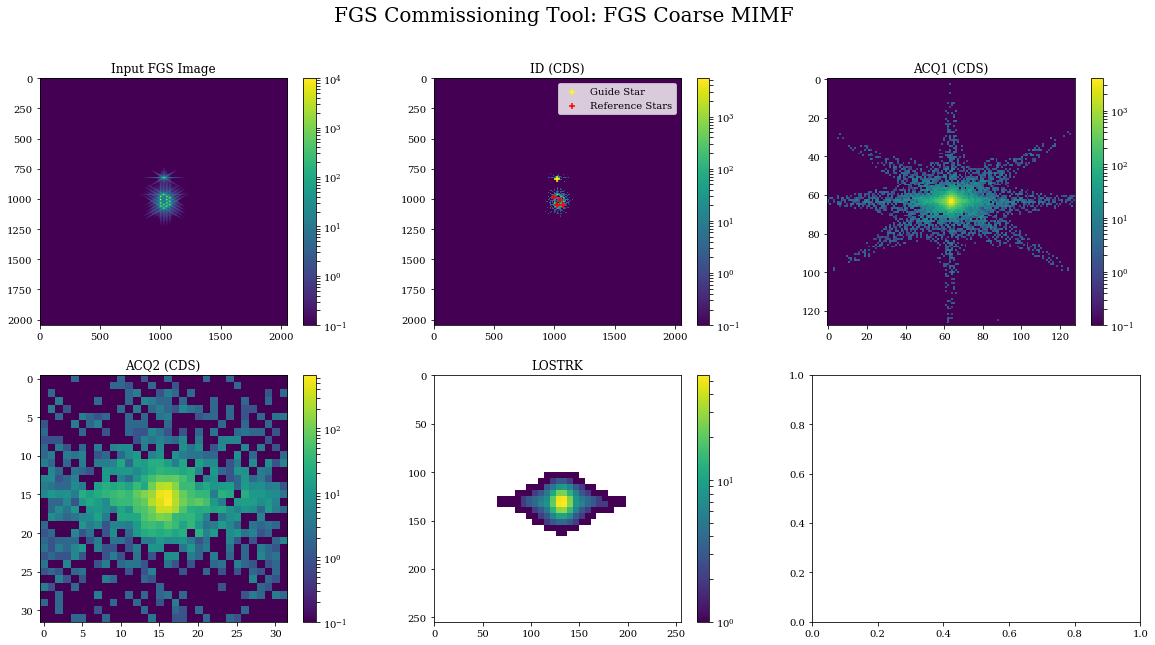

In [62]:
# View the final FGS images
current_dir = os.getcwd()
package_dir = os.path.split(current_dir)[0]
out_dir = os.path.join(package_dir, 'out', root_fgs_cmimf)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('FGS Commissioning Tool: FGS Coarse MIMF', fontsize=20)

in_data = fits.open(input_image_fgs_cmimf)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm(), clim=(1e-1, 1e4))
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input FGS Image')

id_data = fits.open(glob(out_dir + '/stsci/*IDcds.fits')[0])[0].data[0]
id_data[id_data <= 0] = 0.1
implot = ax2.imshow(id_data, norm=LogNorm())
plt.colorbar(implot, ax=ax2)
regfile = glob(out_dir + '/*regfile.txt')[0]
coords = asc.read(regfile)
ax2.scatter(coords['x'][0], coords['y'][0], marker = '+', c= 'yellow', label='Guide Star')
ax2.scatter(coords['x'][1:], coords['y'][1:], marker = '+', c= 'r', label='Reference Stars')
ax2.legend()
ax2.set_title('ID (CDS)')

acq1_data = fits.open(glob(out_dir + '/stsci/*ACQ1cds.fits')[0])[0].data[0]
acq1_data[acq1_data <= 0] = 0.1
implot = ax3.imshow(acq1_data, norm=LogNorm())
plt.colorbar(implot, ax=ax3)
ax3.set_title('ACQ1 (CDS)')

acq2_data = fits.open(glob(out_dir + '/stsci/*ACQ2cds.fits')[0])[0].data[0]
acq2_data[acq2_data <= 0] = 0.1
implot = ax4.imshow(acq2_data, norm=LogNorm())
plt.colorbar(implot, ax=ax4)
ax4.set_title('ACQ2 (CDS)')

lostrk_data = fits.open(glob(out_dir + '/dhas/*LOSTRK.fits')[0])[0].data
lostrk_data[lostrk_data <= 0] = 0.1
implot = ax5.imshow(lostrk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax5)
ax5.set_title('LOSTRK')

# trk_data = fits.open(glob(out_dir + '/dhas/*_TRK.fits')[0])[0].data
# trk_data = trk_data[3] - trk_data[0]
# trk_data[trk_data <= 0] = 0.1
# implot = ax6.imshow(trk_data, norm=LogNorm())
# plt.colorbar(implot, ax=ax6)
# ax6.set_title('TRK (CDS)')

plt.show()

<a id='GANIRCam'></a>
### Example: NIRCam Global Alignment Image

In [63]:
input_image_nc_ga = '/user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_044_001_01100_00000_NRCA3_img.fits'
guider = 1
root_nc_ga = 'tool_tutorial_ncga'

NC = True # default
nircam_mod = None # default

fgs_counts = None # default
jmag = None # default

GA = True

bkgd_stars = False # default

in_file = None # default

In [64]:
run_fgs_commissioning_tool.run_all(input_image_nc_ga, guider, root=root_nc_ga, global_alignment=GA, nircam=NC)

2018-02-12 09:56:32,597 INFO     Started logging to /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/logs/2018_02_12_Mon_095632_run_all_tool_tutorial_ncga.log
2018-02-12 09:56:32,599 INFO     Processing request for tool_tutorial_ncga. 
All data will be saved in: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/tool_tutorial_ncga
2018-02-12 09:56:32,600 INFO     Input image: /user/lchambers/FGS/tool_tutorial/NIRCam_files/jw00000_044_001_01100_00000_NRCA3_img.fits
2018-02-12 09:56:32,601 INFO     This is a NIRCam image
2018-02-12 09:56:32,602 WARNING  No counts or J magnitude given, setting to default
2018-02-12 09:56:32,602 INFO     J magnitude = 11.0
2018-02-12 09:56:32,621 INFO     Beginning to create FGS image from jw00000_044_001_01100_00000_NRCA3_img
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/jw00000_044_001_01100_00000_NRCA3_img/FGS_imgs/jw00000_044_001_01100_00000_NRCA3_img_G1_binned_pad_norm.fits
Finished for jw0000

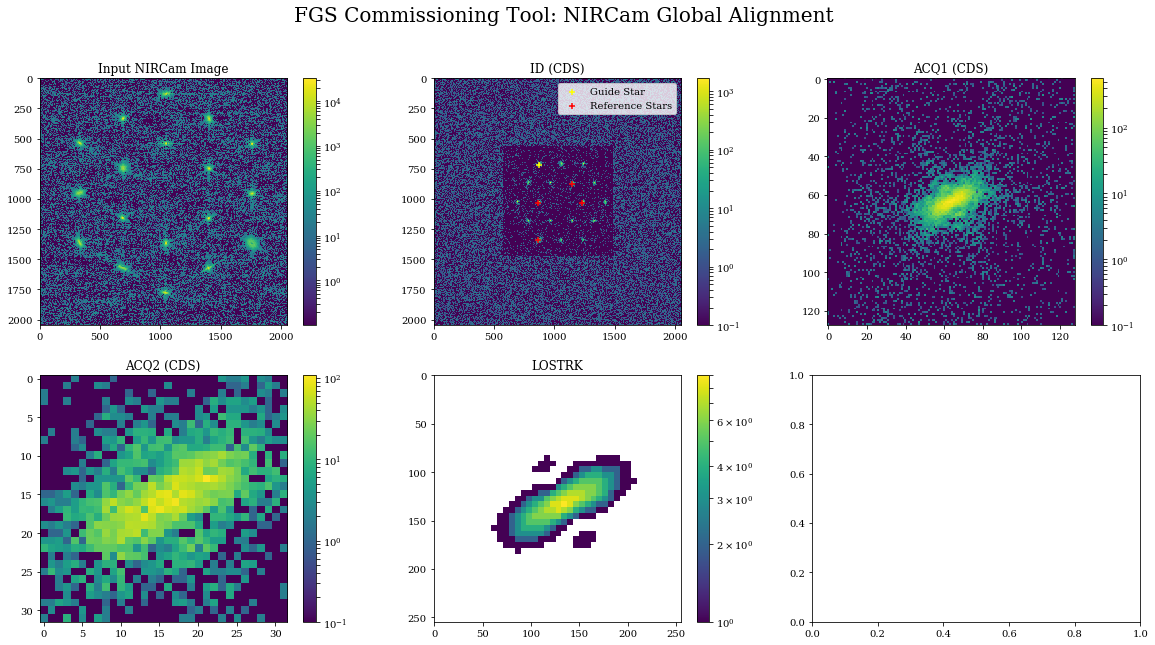

In [66]:
# View the final FGS images
current_dir = os.getcwd()
package_dir = os.path.split(current_dir)[0]
out_dir = os.path.join(package_dir, 'out', root_nc_ga)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('FGS Commissioning Tool: NIRCam Global Alignment', fontsize=20)

in_data = fits.open(input_image_nc_ga)[1].data
in_data[in_data <= 0] = 0.1
implot = ax1.imshow(in_data, norm=LogNorm())
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input NIRCam Image')

id_data = fits.open(glob(out_dir + '/stsci/*IDcds.fits')[0])[0].data[0]
id_data[id_data <= 0] = 0.1
implot = ax2.imshow(id_data, norm=LogNorm())
plt.colorbar(implot, ax=ax2)
regfile = glob(out_dir + '/*regfile.txt')[0]
coords = asc.read(regfile)
ax2.scatter(coords['x'][0], coords['y'][0], marker = '+', c= 'yellow', label='Guide Star')
ax2.scatter(coords['x'][1:], coords['y'][1:], marker = '+', c= 'r', label='Reference Stars')
ax2.legend()
ax2.set_title('ID (CDS)')

acq1_data = fits.open(glob(out_dir + '/stsci/*ACQ1cds.fits')[0])[0].data[0]
acq1_data[acq1_data <= 0] = 0.1
implot = ax3.imshow(acq1_data, norm=LogNorm())
plt.colorbar(implot, ax=ax3)
ax3.set_title('ACQ1 (CDS)')

acq2_data = fits.open(glob(out_dir + '/stsci/*ACQ2cds.fits')[0])[0].data[0]
acq2_data[acq2_data <= 0] = 0.1
implot = ax4.imshow(acq2_data, norm=LogNorm())
plt.colorbar(implot, ax=ax4)
ax4.set_title('ACQ2 (CDS)')

lostrk_data = fits.open(glob(out_dir + '/dhas/*LOSTRK.fits')[0])[0].data
lostrk_data[lostrk_data <= 0] = 0.1
implot = ax5.imshow(lostrk_data, norm=LogNorm())
plt.colorbar(implot, ax=ax5)
ax5.set_title('LOSTRK')

# trk_data = fits.open(glob(out_dir + '/dhas/*_TRK.fits')[0])[0].data
# trk_data = trk_data[1] - trk_data[0]
# trk_data[trk_data <= 0] = 0.1
# implot = ax6.imshow(trk_data, norm=LogNorm())
# plt.colorbar(implot, ax=ax6)
# ax6.set_title('TRK (CDS)')

plt.show()

<a id='nircamtofgs'></a>
# How to convert NIRCam images to FGS images outside of the tool: nircam_to_fgs.py

The `nircam_to_fgs` function takes the following arguments:
* The `input_image` (filepath, directory, or list of filepaths) and `guider` number are required. 
* The `nircam_mod` argument can be used to specify the module of a provided NIRCam image. If left blank, the module will be extracted from the header of the NIRCam FITS file.
* The `fgs_counts` and `jmag` parameters are used to normalize the input NIRCam image, either to a desired J magnitude or to a desired number of FGS counts. If neither are defined, the tool will use a default of jmag = 11.
* If `return_im` is set to `True`, then the function call will output the array of output images.
* The output FGS image(s) will be saved to `output_path`. If the output path is not provided, the image(s) will be saved to `./out/{input_image}`.

**Note:** Like the full tool, running nircam_to_fgs.py will create an `out` directory (whether you want it to or not) in the directory where you are running this script. Inside the `./out/` directory will be directories for every image that you run the script for, with the output FGS `bin_norm_img.fits` inside.

In [67]:
from jwst_fgs_commissioning_tools.nircam_to_fgs import nircam_to_fgs

In [68]:
input_im = '/user/lchambers/FGS/tool_tutorial/NIRCam_files/' # Providing a directory
guider = 2

fgs_counts = None # default
jmag = None # default

nircam_mod = None # default

return_im = True # default
output_path = None # default

In [69]:
fgs_im = nircam_to_fgs.convert_im(input_im, guider, return_im=True, output_path=None)

2018-02-12 09:58:03,737 WARNING  No counts or J magnitude given, setting to default
2018-02-12 09:58:03,739 INFO     J magnitude = 11.0
2018-02-12 09:58:03,742 INFO     Beginning to create FGS image from jw00000_231_001_01100_00000_NRCA3_img
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/jw00000_231_001_01100_00000_NRCA3_img/FGS_imgs/jw00000_231_001_01100_00000_NRCA3_img_G2_binned_pad_norm.fits
Finished for jw00000_231_001_01100_00000_NRCA3_img, Guider = 2
2018-02-12 09:58:08,219 INFO     Beginning to create FGS image from jw00000_044_001_01100_00000_NRCA3_img
Successfully wrote: /Users/lchambers/TEL/Commissioning/Tools/fgs-commissioning/out/jw00000_044_001_01100_00000_NRCA3_img/FGS_imgs/jw00000_044_001_01100_00000_NRCA3_img_G2_binned_pad_norm.fits
Finished for jw00000_044_001_01100_00000_NRCA3_img, Guider = 2
2018-02-12 09:58:11,011 INFO     Beginning to create FGS image from jw00000_231_001_01100_00001_NRCA3_img
Successfully wrote: /Users/lchambers

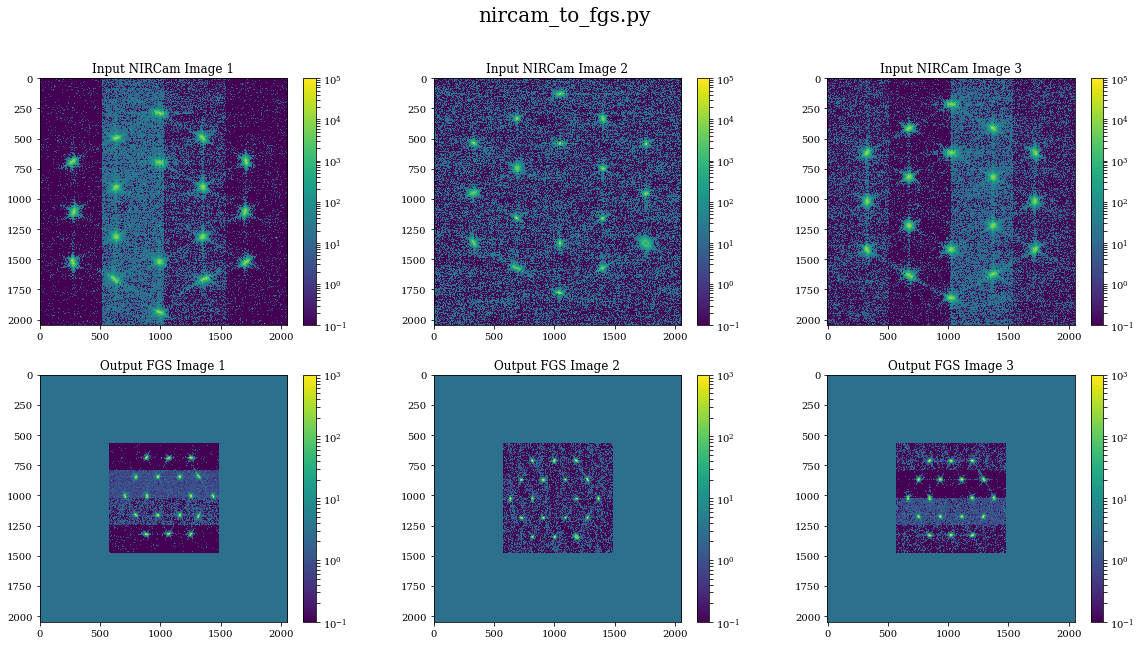

In [21]:
# View the input NIRCam images and output FGS images
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('nircam_to_fgs.py', fontsize=20)

in_files = glob(input_im + '*.fits')

in_data1 = fits.open(in_files[0])[1].data
in_data1[in_data1 <= 0] = 0.1
implot = ax1.imshow(in_data1, norm=LogNorm(), clim=(1e-1, 1e5))
plt.colorbar(implot, ax=ax1)
ax1.set_title('Input NIRCam Image 1')

in_data2 = fits.open(in_files[1])[1].data
in_data2[in_data2 <= 0] = 0.1
implot = ax2.imshow(in_data2, norm=LogNorm(), clim=(1e-1, 1e5))
plt.colorbar(implot, ax=ax2)
ax2.set_title('Input NIRCam Image 2')

in_data3 = fits.open(in_files[2])[1].data
in_data3[in_data3 <= 0] = 0.1
implot = ax3.imshow(in_data3, norm=LogNorm(), clim=(1e-1, 1e5))
plt.colorbar(implot, ax=ax3)
ax3.set_title('Input NIRCam Image 3')

out_data1 = fgs_im[0]
out_data1[out_data1 <= 0] = 0.1
implot = ax4.imshow(out_data1, norm=LogNorm(), clim=(1e-1, 1e3))
plt.colorbar(implot , ax=ax4)
ax4.set_title('Output FGS Image 1')

out_data2 = fgs_im[1]
out_data2[out_data2 <= 0] = 0.1
implot = ax5.imshow(out_data2, norm=LogNorm(), clim=(1e-1, 1e3))
plt.colorbar(implot, ax=ax5)
ax5.set_title('Output FGS Image 2')

out_data3 = fgs_im[2]
out_data3[out_data3 <= 0] = 0.1
implot = ax6.imshow(out_data3, norm=LogNorm(), clim=(1e-1, 1e3))
plt.colorbar(implot, ax=ax6)
ax6.set_title('Output FGS Image 3')

plt.show()